<a href="https://colab.research.google.com/github/WTeam2024/rag_chatbot/blob/main/chatbot_WTeam_OpenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT TEXT MINING 2024 - **W_TEAM** - OpenAI adaptation - see our [github repo](https://github.com/WTeam2024/rag_chatbot) 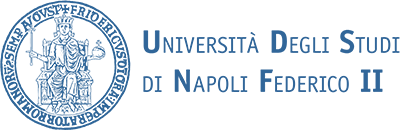

**Changes from standard code:**
*   'flagOAI' needs to be set (and set "OPENAI_API_KEY" in case);
*   import OpenAI LLM through 'ChatOpenAI';
*   loaded the OpenAI 'embedding' model through 'OpenAIEmbeddings'.



## **INSTALL REQUIRED PACKAGES**

In [ ]:
!pip install -q peft  accelerate bitsandbytes safetensors sentencepiece streamlit chromadb langchain sentence-transformers gradio pypdf langchain-community
!pip install -U transformers
!pip install -i https://pypi.org/simple/ bitsandbytes
!pip install accelerate

## IMPORT DEPENDENCIES

In [ ]:
# fixing unicode error in google colab
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline

import os
import gradio as gr
from google.colab import drive

import chromadb
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain import HuggingFacePipeline
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

## CHOOSE THE LLM MODEL (FROM **HUGGINGFACE** OR **OpenAI**)

Set ``flagOAI`` to true if you want to use OpenAI models.



In [ ]:
flagOAI=False

if(flagOAI):
  os.environ["OPENAI_API_KEY"] = "Set-Your-Key"
else:
  model_name = "swap-uniba/LLaMAntino-3-ANITA-8B-Inst-DPO-ITA"

### IMPORT THE QUANTIZED MODEL IN ORDER TO REDUCE THE RESOURCES CONSUMED

In [ ]:
# function for loading 4-bit quantized model
def load_quantized_model(model_name: str):
    """
    :param model_name: Name or path of the model to be loaded.
    :return: Loaded quantized model.
    """
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config
    )
    return model

In [ ]:
# function for initializing tokenizer
def initialize_tokenizer(model_name: str):
    """
    Initialize the tokenizer with the specified model_name.

    :param model_name: Name or path of the model for tokenizer initialization.
    :return: Initialized tokenizer.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.bos_token_id = 1  # Set beginning of sentence token id
    return tokenizer

### CREATE THE COLAB SECRETE NAMED *'HF_TOKEN'* WITH YOUR HUGGING FACE API KEY

In [ ]:
if not flagOAI:
  from google.colab import userdata
  userdata.get('HF_TOKEN')

In [ ]:
if not flagOAI:
  # load model
  model = load_quantized_model(model_name)

  # initialize tokenizer
  tokenizer = initialize_tokenizer(model_name)

  # specify stop token ids
  stop_token_ids = [0]
else:
  from langchain.chat_models import ChatOpenAI
  llm = ChatOpenAI(
      model="gpt-4o",
      temperature=0,
      max_tokens=None,
      timeout=None,
      max_retries=2,
      # api_key="...",  # if you prefer to pass api key in directly instaed of using env vars
      # base_url="...",
      # organization="...",
      # other params...
  )

more information on ``ChatOpenAI`` [here](https://platform.openai.com/docs/models)

## UPLOAD YOUR FILES IN GOOGLE DRIVE INSIDE THE FOLDER *'documents_colab'*

In [ ]:
# mount google drive and specify folder path
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/documents_colab/'

### SINCE THE PDFs CAN BE STRUCTURED IN SUB-FOLDERS, WE NEED TO MOVE ALL OF THEM IN A SINGLE FOLDER (*'/PDFs'*)

In [ ]:
import os
import shutil

source_dir = folder_path
destination_dir = '/content/PDFs'

# if destination_dir does not exist, then create it
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# move the PDFs
def move_pdfs(source, destination):
    for root, dirs, files in os.walk(source):
        for file in files:
            if file.lower().endswith('.pdf'):
                source_file = os.path.join(root, file)
                destination_file = os.path.join(destination, file)
                shutil.copy(source_file, destination_file)
                print(f'Spostato: {source_file} -> {destination_file}')

# run the function
move_pdfs(source_dir, destination_dir)
folder_path = destination_dir

## LOAD, SPLIT -> RETRIEVER

In [ ]:
# load pdf files
loader = PyPDFDirectoryLoader(folder_path)
documents = loader.load()

### CHOOSE THE '*chunk_size*' AND '*chunk_overlap*'

In [ ]:
# split the documents in small chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200) #Chage the chunk_size and chunk_overlap as needed
all_splits = text_splitter.split_documents(documents)

# Check the first few splits to ensure coherence
for i, split in enumerate(all_splits[:3]):
    print(f"Chunk {i+1}:\n{split}\n{'-'*20}")

## CHOOSE YOUR EMBEDDING MODEL ([what embeddings are?](https://huggingface.co/blog/getting-started-with-embeddings))

[documentation](https://api.python.langchain.com/en/latest/embeddings/langchain_community.embeddings.openai.OpenAIEmbeddings.html) of OpenAIEmbeddings.

In [ ]:
if (flagOAI):
  from langchain.embeddings import OpenAIEmbeddings
  embeddings = OpenAIEmbeddings(
      deployment="your-embeddings-deployment-name",
      model="your-embeddings-model-name"
      ### others parameters possible...
  )
else:
  # specify embedding model (using huggingface sentence transformer)
  embedding_model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
  #device = torch.device('cpu')
  model_kwargs = {"device": "cuda"}
  embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name, model_kwargs=model_kwargs)

### CREATE THE RETRIEVER THAT WILL BE USED BY THE LLM ([ChromaDB](https://www.trychroma.com/))

In [ ]:
#embed document chunks
vectordb = Chroma.from_documents(documents=all_splits, embedding=embeddings, persist_directory="chroma_db")

# specify the retriever
retriever = vectordb.as_retriever()

## DEFINE THE PIPELINE FOR THE LLM MODEL AND THE CONVERSATION MODEL ([pipelines definition hugging face](https://huggingface.co/docs/transformers/main_classes/pipelines))

In [ ]:
if not flagOAI:
  # build huggingface pipeline
  pipeline = pipeline(
          model=model,
          tokenizer=tokenizer,
          return_full_text=True, # langchain expects the full text
          task='text-generation',
          max_new_tokens=512, # max number of tokens to generate in the output
          temperature=0.6,  #temperature for more or less creative answers
          do_sample=True,
          top_p=0.9,
  )

  # specify the llm
  llm = HuggingFacePipeline(pipeline=pipeline)

In [ ]:
# build conversational retrieval chain with memory (rag) using langchain
def create_conversation(query: str, chat_history: list) -> tuple:
    try:

        memory = ConversationBufferMemory(
            memory_key='chat_history',
            return_messages=False
        )
        qa_chain = ConversationalRetrievalChain.from_llm(
            llm=llm,
            retriever=retriever,
            memory=memory,
            get_chat_history=lambda h: h,
        )

        result = qa_chain({'question': query, 'chat_history': chat_history})
        chat_history.append((query, result['answer']))
        return '', chat_history

    except Exception as e:
        chat_history.append((query, e))
        return '', chat_history

## USE GRADIO FOR THE UI

In [ ]:
# build gradio ui

js = """
function createGradioAnimation() {
    var container = document.createElement('div');
    container.id = 'gradio-animation';
    container.style.fontSize = '2em';
    container.style.fontWeight = 'bold';
    container.style.textAlign = 'center';
    container.style.marginBottom = '20px';

    var text = 'Chatbot W_Team 2024!';
    for (var i = 0; i < text.length; i++) {
        (function(i){
            setTimeout(function(){
                var letter = document.createElement('span');
                letter.style.opacity = '0';
                letter.style.transition = 'opacity 0.5s';
                letter.innerText = text[i];

                container.appendChild(letter);

                setTimeout(function() {
                    letter.style.opacity = '1';
                }, 50);
            }, i * 250);
        })(i);
    }

    var gradioContainer = document.querySelector('.gradio-container');
    gradioContainer.insertBefore(container, gradioContainer.firstChild);

    return 'Animation created';
}
"""

js2= """
// Funzione per il reindirizzamento
function redirectTo() {
    window.open('https://github.com/WTeam2024/rag_chatbot', '_blank');
}
"""

with gr.Blocks(fill_height=True,js=js,theme=gr.themes.Soft()) as demo:
    chatbot = gr.Chatbot(scale=2,label='Textmining Project - W_Team - 2023/2024')

    with gr.Row():
        with gr.Column(scale=9):
            msg = gr.Textbox(show_label=False, placeholder="Enter question and click on Ask button", lines=2)
        with gr.Column(scale=1):
            submit_btn = gr.Button("Ask", size="sm")
            clear_btn = gr.Button("Clear", size="sm")

    clear_btn.click(fn=lambda: ("", []), inputs=[], outputs=[msg, chatbot])
    submit_btn.click(create_conversation, inputs=[msg, chatbot], outputs=[msg, chatbot])
    msg.submit(create_conversation, [msg, chatbot], [msg, chatbot])
    redirect_button = gr.Button("Follow our project on Github!", variant='secondary')

    redirect_button.click(None, None, None, js=js2)

demo.launch(debug=True, share=True)